In [1]:
#  ___________________________________________________________________________
#
#  Surrogate vs. Implicit: Experiments comparing nonlinear optimization
#  formulations
#
#  Copyright (c) 2023. Triad National Security, LLC. All rights reserved.
#
#  This program was produced under U.S. Government contract 89233218CNA000001
#  for Los Alamos National Laboratory (LANL), which is operated by Triad
#  National Security, LLC for the U.S. Department of Energy/National Nuclear
#  Security Administration. All rights in the program are reserved by Triad
#  National Security, LLC, and the U.S. Department of Energy/National Nuclear
#  Security Administration. The Government is granted for itself and others
#  acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license
#  in this material to reproduce, prepare derivative works, distribute copies
#  to the public, perform publicly and display publicly, and to permit others
#  to do so.
#
#  This software is distributed under the 3-clause BSD license.
#  ___________________________________________________________________________

#### Data Generation for a Gibbs reactor based on the example given in: 

https://idaes.github.io/examples-pse/latest/Examples/UnitModels/Reactors/gibbs_reactor_doc.html.


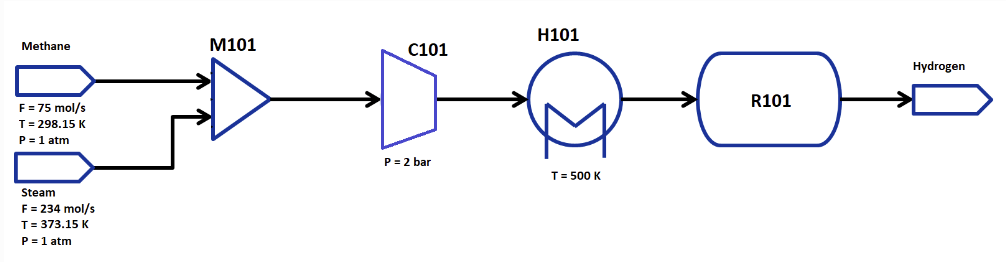

## 1. Import necessary packages. 
- The IDAES version being used is 2.0

In [2]:
import numpy as np
import random 
import pandas as pd
import pyomo.environ as pyo
from idaes.core.util.exceptions import InitializationError
from pyomo.environ import (
    Constraint,
    Var,
    ConcreteModel,
    Expression,
    Objective,
    TransformationFactory,
    value,
    units as pyunits,
)
from pyomo.network import Arc

from idaes.core import FlowsheetBlock
from idaes.models.properties.modular_properties import GenericParameterBlock
from idaes.models.unit_models import (
    Feed,
    Mixer,
    Compressor,
    Heater,
    GibbsReactor,
    Product,
)

from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state
from idaes.models_extra.power_generation.properties.natural_gas_PR import get_prop

## 2. Generate samples for the Gibbs Reactor 

- Inlet flow and compositions are fixed. 
- The reactor does not have pressure change. 
- Inlet temperature and pressure are allowed to change.

In [3]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
thermo_props_config_dict = get_prop(components=["CH4", "H2O", "H2", "CO", "CO2"])
m.fs.thermo_params = GenericParameterBlock(**thermo_props_config_dict)

m.fs.R101 = GibbsReactor(
    property_package=m.fs.thermo_params,
    has_heat_transfer=True,
    has_pressure_change=False,
)

Pin_min = 0.8e6 # Pa
Tin_min = 500 # K
Pin_max = 1.2e6 # Pa
Tin_max = 700 # K

flow_H2O = 234 # mol/s
flow_CH4 = 75 # mol/s
total_flow_in = flow_H2O + flow_CH4

num_samples = 1000

df = {'T_in (K)':[], 'P_in (Pa)':[], 'F_in (mol/s)':[], 'Heat Duty (W)':[], 'F_out (mol/s)':[], 
      'T_out (K)':[], 'H2':[], 'H2O':[], 'CO2':[], 'CO':[], 'CH4':[], 'Conversion':[]}

for i in range(num_samples):
      try:
            Tin = random.uniform(Tin_min, Tin_max)
            Pin = random.uniform(Pin_min, Pin_max)
            m.fs.R101.inlet.temperature.fix(Tin)
            m.fs.R101.inlet.flow_mol.fix(total_flow_in)
            m.fs.R101.inlet.pressure.fix(Pin * pyunits.Pa)
            m.fs.R101.inlet.mole_frac_comp[0, 'CH4'].fix(flow_CH4/total_flow_in)
            m.fs.R101.inlet.mole_frac_comp[0, 'H2'].fix(1e-20)
            m.fs.R101.inlet.mole_frac_comp[0, 'CO'].fix(1e-20)
            m.fs.R101.inlet.mole_frac_comp[0, 'CO2'].fix(1e-20)
            m.fs.R101.inlet.mole_frac_comp[0, 'H2O'].fix(flow_H2O/total_flow_in)
            m.fs.R101.outlet.pressure.fix(Pin * pyunits.Pa)  
            m.fs.R101.initialize()
            solver = get_solver()
            results = solver.solve(m, tee=False)
            df['T_in (K)'].append(Tin)
            df['P_in (Pa)'].append(Pin)
            df['F_in (mol/s)'].append(total_flow_in)
            df['Heat Duty (W)'].append(pyo.value(m.fs.R101.heat_duty[0]))
            df['F_out (mol/s)'].append(pyo.value(m.fs.R101.outlet.flow_mol[0]))
            df['T_out (K)'].append(pyo.value(m.fs.R101.outlet.temperature[0]))
            df['H2'].append(pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "H2"]))
            df['H2O'].append(pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "H2O"]))
            df['CO2'].append(pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "CO2"]))
            df['CO'].append(pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "CO"]))
            df['CH4'].append(pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "CH4"]))
            num = (flow_CH4 - pyo.value(m.fs.R101.outlet.flow_mol[0])*pyo.value(m.fs.R101.outlet.mole_frac_comp[0, "CH4"]))
            den = flow_CH4
            conversion_CH4 = num / den
            df['Conversion'].append(conversion_CH4)
      except InitializationError:
            print(f"Initialization error at {Tin,Pin}.")
            continue
     
        
df = pd.DataFrame(df)

2023-06-01 15:51:50 [INFO] idaes.init.fs.R101.control_volume.properties_in: Starting initialization
2023-06-01 15:51:50 [INFO] idaes.init.fs.R101.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2023-06-01 15:51:50 [INFO] idaes.init.fs.R101.control_volume.properties_out: Starting initialization
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101.control_volume.properties_out: Property initialization: optimal - Optimal Solution Found.
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101.control_volume: Initialization Complete
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101: Initialization Complete: optimal - Optimal Solution Found
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101.control_volume.properties_in: Starting initialization
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2023-06-01 15:51:51 [INFO] idaes.init.fs.R101.control_volume.properties_out: Starting initialization
2

In [4]:
df.head()

,T_in (K),P_in (Pa),F_in (mol/s),Heat Duty (W),F_out (mol/s),T_out (K),H2,H2O,CO2,CO,CH4,Conversion
0,617.548557,9.574715e+05,309,1.521203e+07,407.836145,981.286886,0.433581,0.382521,0.070067,5.110430e-02,0.062726,0.658908
1,660.043593,9.973880e+05,309,2.280207e+07,453.930243,1150.516245,0.530791,0.303986,0.051873,1.077666e-01,0.005584,0.966202
2,560.065810,8.732117e+05,309,-1.579781e+06,309.339253,425.914461,0.002193,0.755354,0.000548,1.000000e-20,0.241904,0.002262
3,539.325533,1.187999e+06,309,-1.072669e+05,310.724333,518.126843,0.011099,0.747530,0.002775,3.948448e-08,0.238597,0.011495
4,560.854834,8.233812e+05,309,1.586530e+07,408.807986,972.457249,0.437441,0.379099,0.071225,5.084732e-02,0.061388,0.665387


In [5]:
df.to_csv('data_gibbs.csv')